In [2]:
import mitsuba as mi
import drjit as dr
from os import chdir, listdir
from PIL import Image, ImageOps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import os
import numpy as np
import torch as ch
mi.set_variant("cuda_ad_rgb")
from mitsuba import ScalarTransform4f as T

(-0.5, 1919.5, 719.5, -0.5)

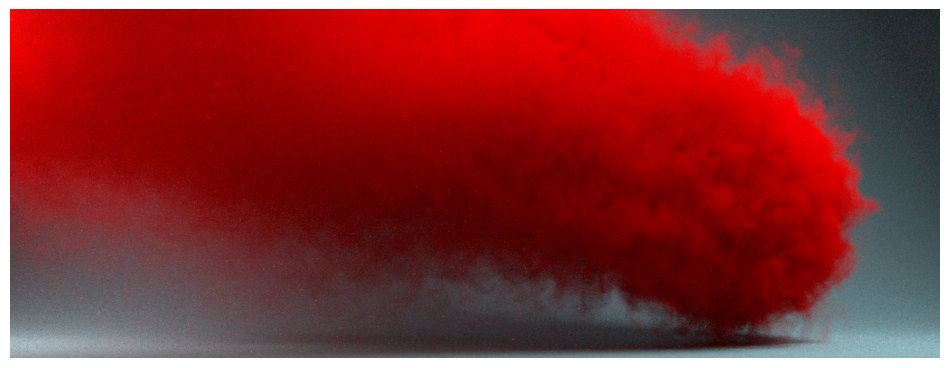

In [6]:
patio = mi.load_file("../scenes/banner_06/scene.xml")
img = mi.render(patio, spp=64, sensor=0)
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
axs.imshow(mi.util.convert_to_bitmap(img))
axs.axis("off")

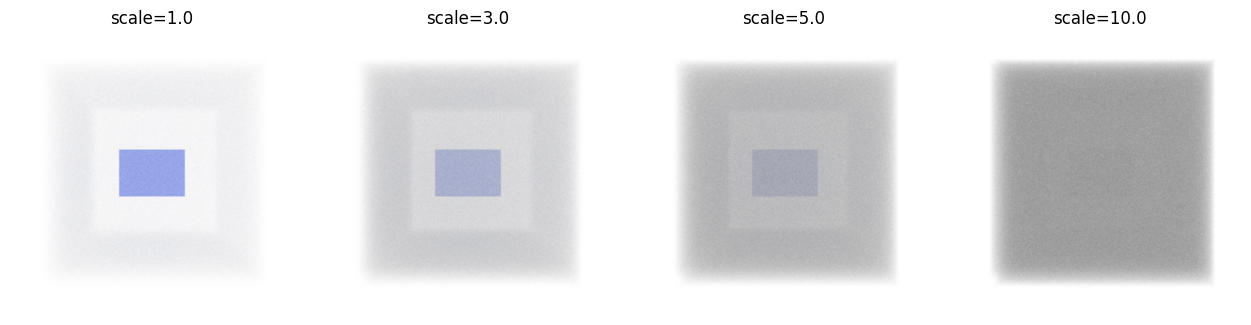

In [76]:
import mitsuba as mi, drjit as dr
import matplotlib.pyplot as plt
mi.set_variant('cuda_ad_rgb')  # or llvm_ad_rgb

T = mi.ScalarTransform4f

def make_scene(density_scale=5.0):
    return mi.load_dict({
        'type': 'scene',
        'integrator': { 'type': 'prbvolpath' },

        # Big, invisible container cube with the fog inside
        'fog_box': {
            'type': 'cube',
            'bsdf': { 'type': 'null' },      # surface invisible
            'interior': {
                'type': 'heterogeneous',
                'sigma_t': {
                    'type': 'gridvolume',
                    'filename': '/nvmescratch/mhull32/revamp/scenes/volume_scene/smoke3.vol',
                    # same mapping you used to align the .vol with the unit cube
                    'to_world': T().rotate([1, 0, 0], -90).scale(2).translate(-0.5)
                },
                'albedo': 0.9,               # scattering color ratio (milky fog)
                'phase': { 'type': 'isotropic' },
                'scale': density_scale       # the knob you’ll sweep
            }
        },

        # Inner blue cube (non-uniform scale -> rectangular box), centered
        'inner_box': {
            'type': 'cube',
            'to_world': T().scale([0.35, 0.25, 0.35]).translate([0.0, 0.0, 0.0]),
            'bsdf': {
                'type': 'diffuse',
                'reflectance': { 'type': 'rgb', 'value': [0.15, 0.25, 0.85] }  # blue
            }
        },

        # Simple environment light so the box is visible through fog
        'emitter': { 'type': 'constant', 'radiance': { 'type': 'rgb', 'value': 1.0 } }
    })

# Keep your existing sensor
sensor = mi.load_dict({
    'type': 'perspective',
    'fov': 45,
    'to_world': T().look_at(origin=[0, 0, 4], target=[0, 0, 0], up=[0, 1, 0]),
    'film': { 'type': 'hdrfilm', 'width': 512, 'height': 512, 'filter': {'type': 'tent'} }
})

# Quick sweep to see visibility change with density
scales = [1.0, 3.0, 5.0, 10.0]
fig, axs = plt.subplots(1, len(scales), figsize=(3.2*len(scales), 3.2))
for ax, s in zip(axs, scales):
    scene = make_scene(density_scale=s)
    img = mi.render(scene, sensor=sensor, spp=64)
    ax.imshow(mi.util.convert_to_bitmap(img))
    ax.set_title(f'scale={s}')
    ax.axis('off')
plt.tight_layout()
plt.show()

(-0.5, 511.5, 511.5, -0.5)

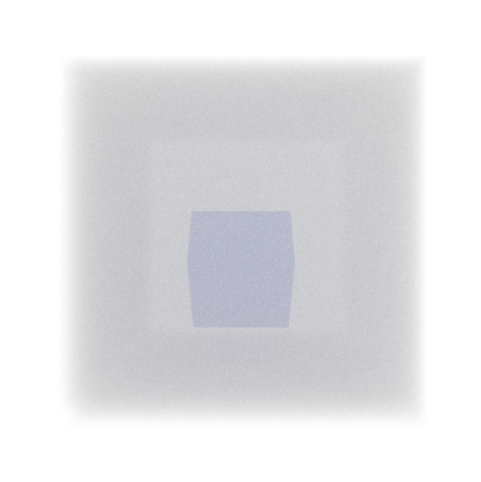

In [113]:
smoke = mi.load_file("../scenes/fog/fog.xml", fog_scale=5.0)
smoke_img = mi.render(smoke, spp=256, sensor=0)
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
axs.imshow(mi.util.convert_to_bitmap(smoke_img))
axs.axis("off")